In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

1.15.0-rc3
2.2.5


Using TensorFlow backend.


In [0]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi


Ngrok already installed


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: https://41c15fa0.ngrok.io


In [0]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

  

In [0]:
# torch and torchvision imports
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim

logger = Logger('./logs')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

In [0]:
import math
math.cos(math.pi/3)

0.5000000000000001

T = 19550
T_0 = 3910
eta_max = 0.3/10 = 0.03

In [0]:


# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Defining the model
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

# The training loop
# t = 0
# T_0 = 3910
# T = 19550
# eta = 0.03
train_loss_array = []
lr_array = []
train_accuracy_array = []
test_loss_array = []
test_error_array = []
def train(net, optimizer, criterion, train_loader, test_loader, epochs, model_name, plot):
    t = 0
    T_0 = 3910
    T = 19550
    eta = 0.15
    trian_correct = 0
    train_total = 0
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    update_lr = 0.0001
    for epoch in range(epochs):
#         optimizer = optim.SGD(model.parameters(), lr=update_lr, weight_decay=0.001)
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(train_loader):
            for g in optimizer.param_groups:
              g['lr'] = update_lr
#             optimizer = optim.SGD(model.parameters(), lr=update_lr,momentum=0.9, weight_decay=0.001)
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            trian_correct += (predicted == labels).sum().item()
            print (update_lr)
#             if (i+1) % 2 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            print ('Epoch [{}/{}], Step [{}/{}], Accuracy: {:.4f} %'.format(epoch+1, epochs, i+1, total_step, 100*trian_correct/train_total))
            train_loss_array.append(loss.item())
            lr_array.append(update_lr)
            train_accuracy_array.append(100*trian_correct/train_total)
            if plot:
              info = { ('loss_' + model_name): loss.item() }

              for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)
            # update learning rate according to specific function
            t += 1
            if t<= T_0:
              update_lr = 0.0001+eta*t/T_0
            else:
              update_lr = eta*math.cos((math.pi/2)*(t-T_0)/(T-T_0))+0.000001



    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            test_error_array.append(100 * correct / total)
            test_loss_array.append(loss.item())
            

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    print('Loss of the network on the test images: {} %'.format(loss.item()))



model = allcnn_t().to(device)
#TODO: Set it as number of epochs states in the question
epochs = 50
# TODO: Define the loss function as asked in the question
criterion = nn.CrossEntropyLoss()
# TODO: Set parameters as stated in the question
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5,weight_decay=0.001)
# Training loop called here
train(model, optimizer, criterion, trainloader, testloader, epochs, 'cnn', True)

Files already downloaded and verified
Files already downloaded and verified
Num parameters:  1667166
0.0001
Epoch [1/50], Step [1/391], Loss: 2.3078
Epoch [1/50], Step [1/391], Accuracy: 11.7188 %
0.0001383631713554987
Epoch [1/50], Step [2/391], Loss: 2.3255
Epoch [1/50], Step [2/391], Accuracy: 10.5469 %
0.00017672634271099743
Epoch [1/50], Step [3/391], Loss: 2.3062
Epoch [1/50], Step [3/391], Accuracy: 10.6771 %
0.00021508951406649614
Epoch [1/50], Step [4/391], Loss: 2.3045
Epoch [1/50], Step [4/391], Accuracy: 10.9375 %
0.00025345268542199486
Epoch [1/50], Step [5/391], Loss: 2.3094
Epoch [1/50], Step [5/391], Accuracy: 11.2500 %
0.00029181585677749363
Epoch [1/50], Step [6/391], Loss: 2.3126
Epoch [1/50], Step [6/391], Accuracy: 10.6771 %
0.0003301790281329923
Epoch [1/50], Step [7/391], Loss: 2.3241
Epoch [1/50], Step [7/391], Accuracy: 10.2679 %
0.00036854219948849107
Epoch [1/50], Step [8/391], Loss: 2.3173
Epoch [1/50], Step [8/391], Accuracy: 10.4492 %
0.0004069053708439897

In [0]:
# train_loss_array = []
# lr_array = []
# train_accuracy_array = []
# test_loss_array = []
# test_error_array = []
# print(len(train_loss_array))
# print(lr_array)
np.savetxt("Training Loss", train_loss_array, delimiter=",")
np.savetxt("Training Accuracy", train_accuracy_array, delimiter=",")
np.savetxt("lr_array", lr_array, delimiter=",")
np.savetxt("Testing Loss", test_loss_array, delimiter=",")
np.savetxt("Testing Accuracy", test_error_array, delimiter=",")


In [0]:
weight_updates = np.arange(1,19551,100)
print(weight_updates.shape)

(196,)


In [0]:
plot_trian_loss = train_loss_array[0:19550:100]

In [0]:
plot_trian_accuracy = train_accuracy_array[0:19550:100]

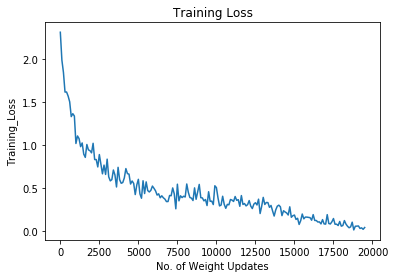

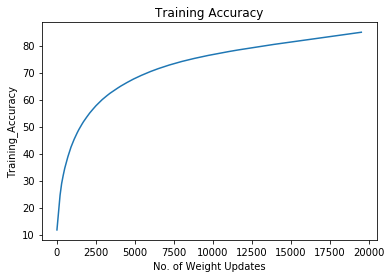

In [0]:
import matplotlib.pyplot as plt
plt.plot(weight_updates,plot_trian_loss,'-')
# plt.xticks(np.arange(min(train_loss_array), max(train_loss_array)+1, 100))
plt.ylabel('Training_Loss')
plt.xlabel('No. of Weight Updates')
plt.title("Training Loss")
plt.savefig('training_loss')
plt.show()


plt.plot(weight_updates,plot_trian_accuracy,'-')
# plt.xticks(np.arange(min(train_loss_array), max(train_loss_array)+1, 100))
plt.ylabel('Training_Accuracy')
plt.xlabel('No. of Weight Updates')
plt.title("Training Accuracy")
plt.savefig('training_accuracy')
plt.show()

# y = train_loss_array[0:270]
# x = lr_array[0:270] 
# fig = plt.figure()
# ax = fig.add_subplot(2, 1, 1)
# ax.set_xscale('log')
# plt.plot(x,y)
# # plt.plot(np.squeeze(train_loss_array[0:150]))
# plt.ylabel('Training_Loss')
# plt.xlabel('Learning Rate')
# plt.title("Training Loss vs Learning Rate_(eta_t+1 = 1.05eta_t)")
# plt.savefig('Training Loss vs Learning Rate_(eta_t+1 = 1.05eta_t).jpg')
# plt.show()
# # np.savetxt("Training Loss vs Learning Rate_1.1", train_loss_array, delimiter=",")

# #local minimum 0.3

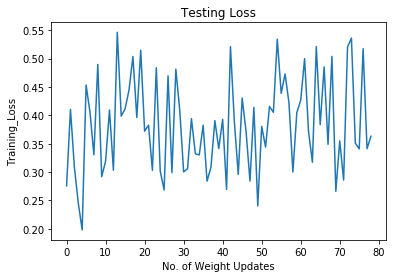

In [0]:
plt.plot(np.squeeze(test_loss_array))
plt.ylabel('Training_Loss')
plt.xlabel('No. of Weight Updates')
plt.title("Testing Loss")
plt.savefig('testing_loss')
plt.show()

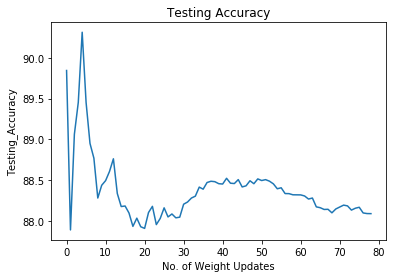

In [0]:
plt.plot(np.squeeze(test_error_array))
plt.ylabel('Testing_Accuracy')
plt.xlabel('No. of Weight Updates')
plt.title("Testing Accuracy")
plt.savefig('testing_accuracy')
plt.show()